Primeiramente iremos gerar alguns dados para suprir a necessidade de ter uma variável alvo de "irrigação ligada" ou "irrigação desligada".

Para isto, consideramos a **temperatura**, **humidade** e **precipitação** para definir se uma plantação deve ser irrigada ou não.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
import joblib

In [2]:
df = pd.read_csv('produtos_agricolas.csv')

**Criação de features**

In [3]:
TEMPERATURE = 25
HUMIDITY = 50
RAINFALL = 100

df['irrigation_on'] = df.apply(lambda x: True if (x['temperature'] >= TEMPERATURE) 
                              and (x['humidity'] < HUMIDITY) 
                              and (x['rainfall'] < RAINFALL)else False, axis=1)

df.rename(columns={'label': 'culture'}, inplace=True)
df.head()

,N,P,K,temperature,humidity,ph,rainfall,culture,irrigation_on
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,False
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,False
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,False
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,False
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N              2200 non-null   int64  
 1   P              2200 non-null   int64  
 2   K              2200 non-null   int64  
 3   temperature    2200 non-null   float64
 4   humidity       2200 non-null   float64
 5   ph             2200 non-null   float64
 6   rainfall       2200 non-null   float64
 7   culture        2200 non-null   object 
 8   irrigation_on  2200 non-null   bool   
dtypes: bool(1), float64(4), int64(3), object(1)
memory usage: 139.8+ KB


Text(0.5, 1.0, 'Matriz de Correlação')

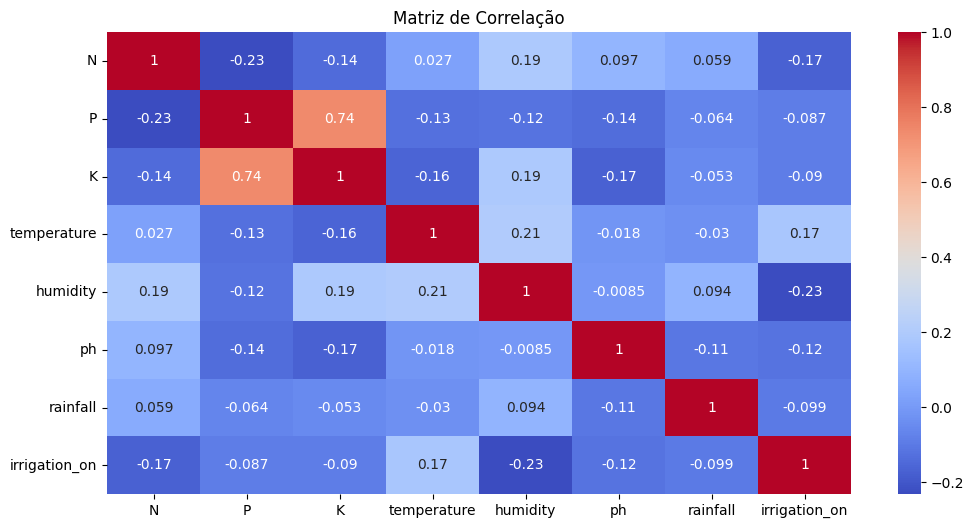

In [5]:
corr = df.select_dtypes(include=['int64', 'float64', 'bool']).corr()

plt.figure(figsize=(12,6))
sns.heatmap(data=corr, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")

### Criando o primeiro modelo (com todos os dados)

In [6]:
X = df.drop(['irrigation_on', 'culture'], axis=1)
y = df['irrigation_on']

**Pré processamento**

In [7]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']),
    ]
)

**Criação do Pipeline**

In [8]:
SEED = 42

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestClassifier(random_state=SEED))
])

In [9]:
def view_cross_validate_scores(results):
    mean = results['test_score'].mean()
    std = results['test_score'].std()
    train_mean = results['train_score'].mean()

    print(f'Acurácia média treino: {train_mean*100:.2f}%')
    print(f'Acurácia média teste: {mean*100:.2f}%')
    print(f'Intervalo de acurácia com validação cruzada: {(mean - 2 * std)*100:.2f}% // {(mean + 2 * std)*100:.2f}%')

**Validação Cruzada para validar o modelo**

In [10]:
results = cross_validate(pipeline, X, y, cv=StratifiedShuffleSplit(n_splits=10, random_state=SEED), return_train_score=True)
view_cross_validate_scores(results)

Acurácia média treino: 100.00%
Acurácia média teste: 99.73%
Intervalo de acurácia com validação cruzada: 99.28% // 100.17%


**Treinamento do modelo**

In [11]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('estimator', RandomForestClassifier(random_state=42))])

O nosso modelo abaixo interpretou como as variáveis mais importantes para o problema de irrigação automática Humidade, Temperatura, Precipitação, porém também interpretou de forma erronea que as outras variáveis também interferem na irrigação estar ligada ou não, sendo que não interferem. Talvez para este momento seja melhor seguirmos com um modelo mais simples para não lidar com esses problemas, pois os dados de irrigação foram gerados, não é uma informação idealmente verdadeira.

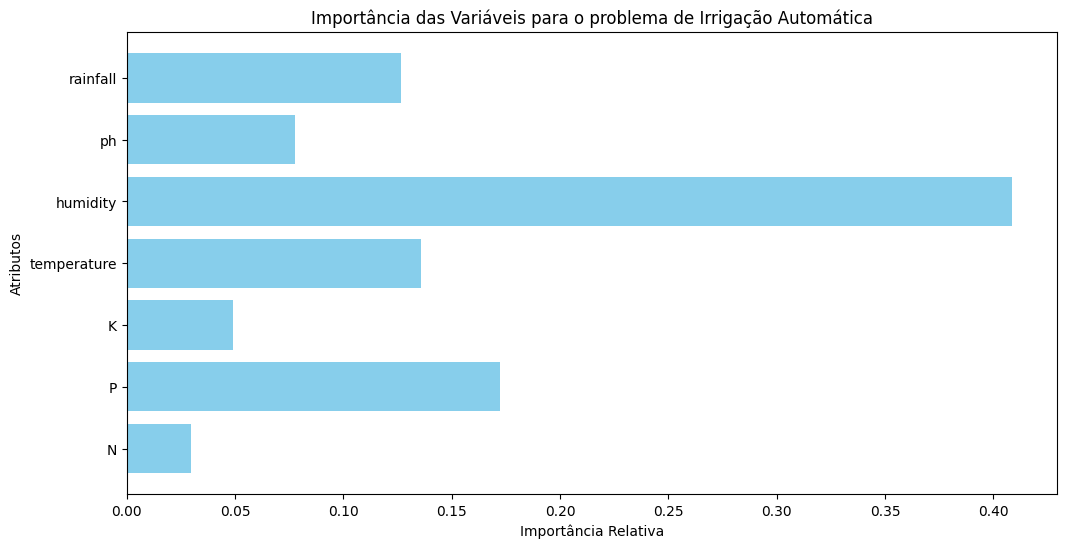

In [12]:
estimator = pipeline.named_steps['estimator']

plt.figure(figsize=(12,6))
plt.barh(X.columns, estimator.feature_importances_, color='skyblue')
plt.xlabel("Importância Relativa")
plt.ylabel("Atributos")
plt.title("Importância das Variáveis para o problema de Irrigação Automática")
plt.show()

### Reformulação do Modelo (mais simples)

Iremos remover as variáveis N, P, K e ph para não confundir o modelo e não deixa-lo complexo demais para o nosso problema neste momento.

In [13]:
X = df.drop(['irrigation_on', 'culture', 'N', 'P', 'K', 'ph'], axis=1)
y = df['irrigation_on']

**Pré processamento**

In [14]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

**Criação da Pipeline**

In [15]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', RandomForestClassifier(random_state=SEED))
])

**Validação Cruzada**

In [16]:
results = cross_validate(pipeline, X, y, cv=StratifiedShuffleSplit(n_splits=10, random_state=SEED), return_train_score=True)
view_cross_validate_scores(results)

Acurácia média treino: 100.00%
Acurácia média teste: 99.91%
Intervalo de acurácia com validação cruzada: 99.55% // 100.27%


**Treinamento do modelo**

In [17]:
pipeline.fit(X, y)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator', RandomForestClassifier(random_state=42))])

Já que utilizamos apenas essas três variáveis de fatores climáticos para definir o acionamento e desligamento da irrigação (rainfall, humidity e temperature), fazemos com que o modelo ficasse mais simples, porém os outros campos estão diretamente ligados à fertilidade do solo e influenciam no crescimento saudável das plantas.

Portanto, para uma aplicação no mundo real o ideal é que estes dados também estivessem presentes para o treinamento no modelo, porém não utilizamos pois não faria sentido para o nosso caso neste momento.

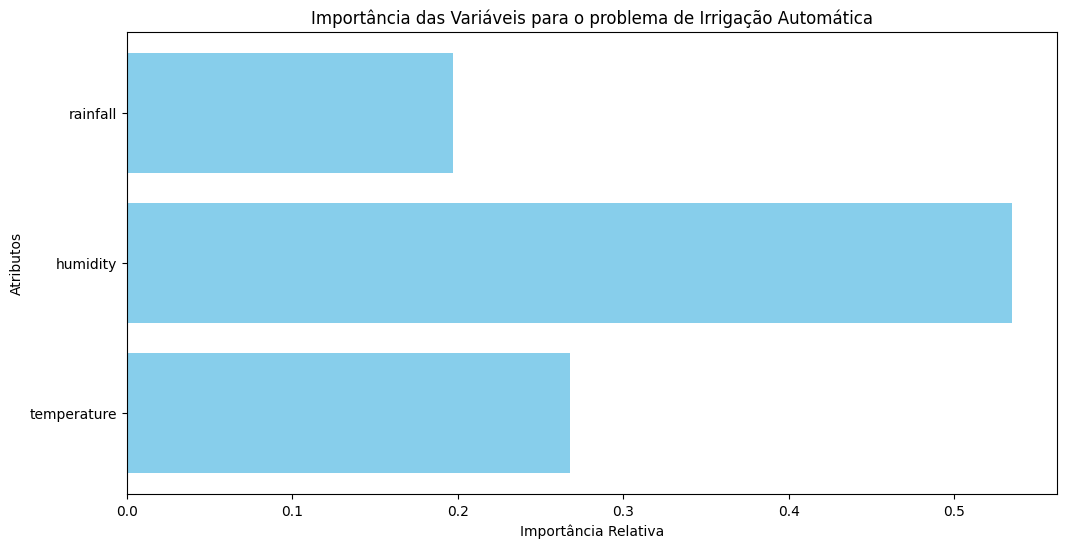

In [18]:
estimator = pipeline.named_steps['estimator']

plt.figure(figsize=(12,6))
plt.barh(X.columns, estimator.feature_importances_, color='skyblue')
plt.xlabel("Importância Relativa")
plt.ylabel("Atributos")
plt.title("Importância das Variáveis para o problema de Irrigação Automática")
plt.show()

**Exportação do modelo**

In [19]:
joblib.dump(pipeline, 'irrigation_automation_model_pipeline.joblib')
print('Modelo exportado.')

Modelo exportado.
